**author: Xiaowu He. horace_hxw_cal@berkeley.edu**

# Multi-label Classification Note
## 1. ECOC(multi-class setting)
#### step 1: map the class to the coresponding **binary** vector $[1,0,...,1]^T$ using the error correction codes.:
- Exhaustive code
- Col Selection from Exhaustive code (Hill Climbing)
- Randomize Hill Climbing
- BCH code

#### step 2: use maching learning algorithms to create the probability vector of each position to be 1.
- Decision Tree
- Nueral Network
- **create muliple binary classifiers for each position**

#### step 3： recover the origin class vector according to the cloest $\ell_1$ distance

## 2. MLGT (Group Testing)
The basic idea is to form group of labels and test each data point whether or not inside that group.
1. Construct  a specific binary matrix $A_{m\times d}$ and compress the original binary-label vector by $z = A \quad or \quad  y$ using matrix boolean opration. Then train the classifiers based on vector z.
2. Predicting process is to set the position $l$ of group vector to 1 iff $|supp(A^{(l)}) - supp(\hat{z}))| < \frac{e}{2}$. where the supp() means the set of indexees of nonzero enties in a given vector.

## 3. Haffman Tree Based multi-class Classification
constructing a haffman tree based on the frequency of each label. and train a binary classifier at each node of the tree.

**this can reduce the average classification and training time.**

## 4. ECOC in Multi-label setting
Assume there are m labels in total and each data point has no more than k labels.
1. we can map each label into a binary representation and concat them into a binary vector of leangth $k\log m$. If some data point doesn't have enough labels, add a default number to maintain the length.
2. Add **parity check**`    ` to the above vector using Error Correction Code
2. Train binary classifier on each digit.


# Implement ECOC in Multi-label Classification
## Set up
we are given a set of labeled trianing data $\{(x_i,y_i)\}_{i=1}^{n}$, where $x_i \in \mathbb{R}^p$ are the input features and $y_i \in \{0,1\}^d$ are vectors indicating the labels of each data point.

In practice, the label vector $y_i$ are sparse. We assume that the labels are at most k-sparse. And want to compress the label vectors into $k \cdot \log m$ length by concating the binary representation of each label index into a binary vector.

In [1]:
!ls

data_clean.py  data_util.py   ECOC_Multi-label.ipynb  LDPC.ipynb
data_clean.sh  data_util.pyc  LDPC


In [2]:
%matplotlib inline
import data_util
import matplotlib.pyplot as plt
import numpy as np
from data_util import DataPoint
import math
from LDPC.LDPCGenerator import LDPCCoder

In [3]:
!ls -R ../data

../data:
AmazonCat  Bibtex  Delicious  Eurlex  Mediamill  RCV1-x  Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt


In [4]:
data_path = "../data"
filename = data_path + "/Eurlex/eurlex_train.txt"
data, num_point, num_feature, num_label = data_util.read_file(filename)

In [5]:
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=15539, num_label=3993, num_feature=5000


## Step 1: Calculate the distribution of number of labels in each data point
if the maximum number k is relatively small, set the length of our label vector into $k\cdot \left \lceil {\log m} \right \rceil$

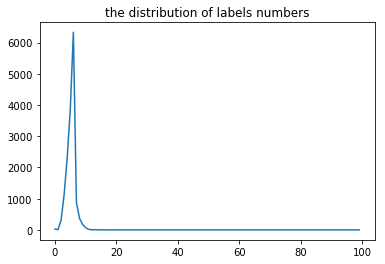

In [6]:
# find the distribution of num of labels in each data point
label_lengths = [0 for _ in range(num_label + 1)]
for data_point in data:
    label_lengths[len(data_point.labels)] += 1
plt.plot(label_lengths[:100])
plt.title("the distribution of labels numbers")

(15539, 15539)


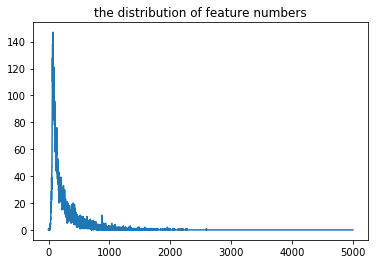

In [7]:
# find the distribution of num of features in each data point
feature_lengths = [0 for _ in range(num_feature + 1)]
for data_point in data:
    feature_lengths[len(data_point.features)] += 1
plt.plot(feature_lengths[:5000])
plt.title("the distribution of feature numbers")
print(sum(label_lengths), sum(feature_lengths))

In [8]:
# find the 99% value over a population
def find_percent(data, population, percent=0.99):
    target = population*(1-percent)
    for i in range(len(data)):
        population -= data[i]
        if population <= target:
            return i

label_k = find_percent(label_lengths, num_point)
print("99% of data points has less than {} labels and less than {} features"\
      .format(label_k, find_percent(feature_lengths, num_point)))

99% of data points has less than 9 labels and less than 1205 features


length = 5001


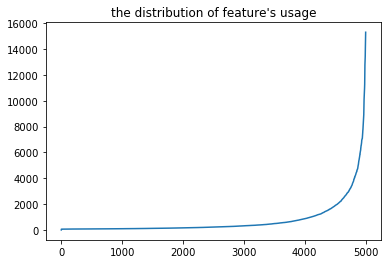

In [9]:
# find the distribution of usage of each feature
feature_nums = [0 for _ in range(num_feature + 1)]
print ("length = {}".format(len(feature_nums)))
for data_point in data:
    for feature in data_point.features:
        try:
            feature_nums[feature] += 1
        except IndexError:
            print feature
plt.plot(sorted(feature_nums))
plt.title("the distribution of feature's usage")

In [10]:
labels_set, features_set = set(), set()
for data_point in data:
    for label in data_point.labels:
        labels_set.add(label)
    for feature in data_point.features:
        features_set.add(feature)
print("the range of lables are ({}, {})\nthe range of features are ({}, {})"\
     .format(min(labels_set), max(labels_set), min(features_set), max(features_set)))

the range of lables are (0, 3992)
the range of features are (0, 4999)


The above information might be useful for furthur optimize the parameters.

## Step 2: Generator Label vectors
The training and predicting process can be viewed as a channel transmition during a binary symetric channel. We first do source encoding to compress the labels information and then do channel encoding to ad the parity check to resist the channel error.
### 2.1 Source Encoding: create the compressed lable vec
For each data point's label, we first translate its labels into binary form and then concat them one by one in ascent order. the default value for the label vector would be "111..1".


In [11]:
def num_to_bin(x, length=None):
    '''
    convert a single lable to corresponding binary vector
    '''
    if length == None:
        length=int(math.log(x)/math.log(2)) + 1
    bits = [0]*length
    i = 0
    while x:
        bits[i] = x%2
        x >>= 1
        i+=1
    return bits

def l_to_vec(labels, k, length):
    '''
    compress the lable vector.
    input:
        k: maximum non-zero entries of lable in a data point
        length: length of each binary bevtor for a label
    '''

    labels.sort() #ascending order
    default_place = [1]*length
    vec = []
    for i in range(k):
        if i < len(labels):
            vec.extend(num_to_bin(labels[i], length))
        else:
            vec.extend(default_place)
    return (np.array(vec))
    
l_to_vec([1,2,3], 4, 2)


array([1, 0, 0, 1, 1, 1, 1, 1])

In [12]:
ms_length = int(math.log(max(labels_set))/math.log(2)) + 1
Y_tr = [l_to_vec(data_point.labels, label_k, ms_length) for data_point in data]

In [13]:
len(Y_tr[0])

108

### 2.2 Channel Encoding: Add parity check to label vector
we apply the traditional error correcting codes to the label vector to get a fixed length new output vector.

Here, we use the LDPC(Low-density parity-check code) to encode the  compessed label vectors.

The details of LDPC can be seen [here](https://en.wikipedia.org/wiki/Low-density_parity-check_code)

the LDPCCoder class is like this:
```Python
    >> ldpc = LDPCCoder(10)
    >> received_codeword = ldpc.encode([0,0,0,1,0,1,1,1,1,1])
    >> for i in xrange(len(received_codeword)):
    ....   if np.random.rand() > 0.95:
    ....   received_codeword[i] = 1 - received_codeword[i]
    >> ldpc.decode(received_codeword)
    array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1])
```

In [14]:
n = 10 # we can translate 10 bits.
ldpc = LDPCCoder(n, flip_p=0.05)
print("message length = {}, code_word length ={}".format(ldpc.bits, ldpc.code_length))

message length = 10, code_word length =24


In [15]:
Y_tr = [ldpc.encode(label_vec) for label_vec in Y_tr]

In [16]:
len(Y_tr[0]) 

264

## Step3: train the classifiers
train binary classifers for each of the input (X_tr,Y_tr) data

In [17]:
from sklearn import svm